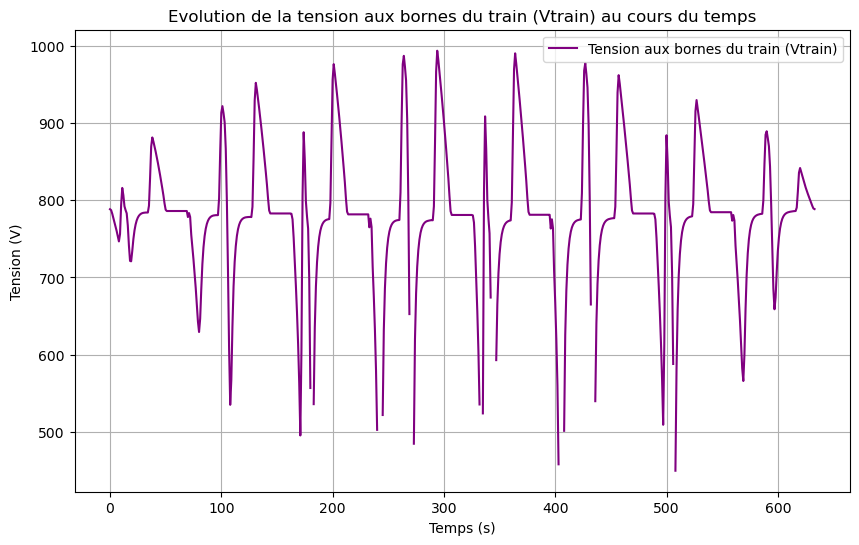

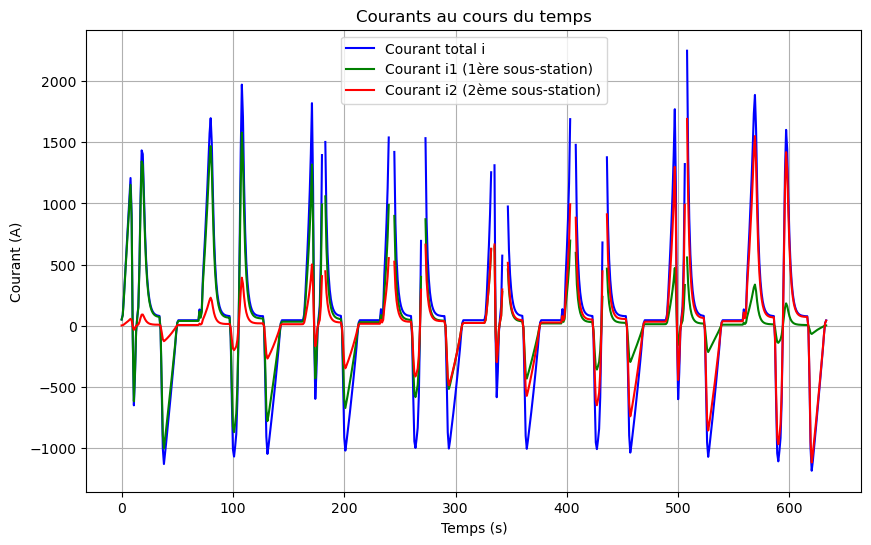

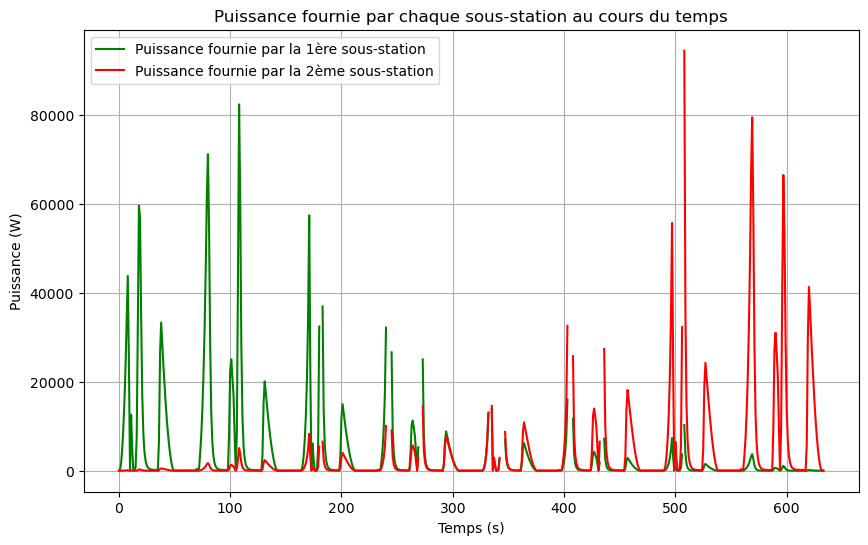

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Données du problème
Vsst = 790  
Rsst = 33e-3  
RLAC_per_m = 131e-6  
Rrail_per_m = 18e-6  

# Charger les données de la marche du train
data = np.loadtxt('marche_train.txt')  
temps = data[:, 0]
position_x = data[:, 1] 
# Fonction pour calculer RLAC et Rrail
def calculer_RLAC(x):
    return RLAC_per_m * x

def calculer_Rrail(x):
    return Rrail_per_m * x

# Fonction pour calculer Req
def calculer_Req(x):
    RLAC1 = calculer_RLAC(x)
    Rrail1 = calculer_Rrail(x)
    RLAC2 = calculer_RLAC(5000 - x)  # Longueur totale de 5 km
    Rrail2 = calculer_Rrail(5000 - x)
    R1 = RLAC1 + Rrail1 + Rsst
    R2 = RLAC2 + Rrail2 + Rsst
    return ( (R1*R2)/(R1 + R2 ) )

# Fonction pour calculer la puissance mécanique
def calculer_puissance_mecanique(temps, position_x):
    vitesse = np.gradient(position_x, temps)
    acceleration = np.gradient(vitesse, temps)

    # Paramètres pour le calcul de la force résistive
    M = 70000 
    Ao = 780
    A1 = 6.4
    Bo = 0
    B1 = 0.14
    Co = 0.3634
    C1 = 0

    # Force résistive
    Fresistive = (Ao + A1 * M/1000) + (Bo + B1 * M/1000) * vitesse + (Co + C1 * M/1000) * vitesse**2

    # Force motrice
    Fmotrice = M * acceleration + M * 9.81 * np.sin(0) + Fresistive  # En supposant une pente nulle pour le moment

    Pmechanique = Fmotrice * vitesse
    return Pmechanique

Pmechanique = calculer_puissance_mecanique(temps, position_x)
ptrain =0
# Calcul de la puissance électrique consommée
if (ptrain >= 0 ) :
    Ptrain = Pmechanique / 0.80 + 35000 
else : 
    Ptrain = Pmechanique * 0.80 + 35000 
    
     # Rendement de 80% et consommation constante de 35 kW

# 1. Calcul de Vtrain
Vtrain = []
for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    delta = Vsst**2 - 4 * Req * P
    if delta >= 0:
        V = 0.5 * (Vsst + np.sqrt(delta))
        Vtrain.append(V)
    else:
        Vtrain.append(np.nan)

# 2. Calcul des courants et des puissances (en dehors de la boucle de Vtrain)
i = []
i1 = []
i2 = []
P1 = []
P2 = []

for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    V = Vtrain[idx]
    i_value = (Vsst - V) / Req
    i.append(i_value)
    # Calcul des courants i1 et i2
    i1_value = (Vsst - V) / (Rsst + calculer_RLAC(x) + calculer_Rrail(x))
    i2_value = (Vsst - V) / (Rsst + calculer_RLAC(5000 - x) + calculer_Rrail(5000 - x))
    P1_value = (Rsst ) * i1_value**2 
    P2_value = (Rsst ) * i2_value**2 
    i1.append(i1_value)
    i2.append(i2_value)
    P1.append(P1_value)
    P2.append(P2_value)

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(temps, Vtrain, label='Tension aux bornes du train (Vtrain)', color='purple')
plt.title('Evolution de la tension aux bornes du train (Vtrain) au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les courants (i, i1, i2)
plt.figure(figsize=(10, 6))
plt.plot(temps, i, label='Courant total i', color='blue')
plt.plot(temps, i1, label='Courant i1 (1ère sous-station)', color='green')
plt.plot(temps, i2, label='Courant i2 (2ème sous-station)', color='red')
plt.title('Courants au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Courant (A)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les puissances (P1 et P2)
plt.figure(figsize=(10, 6))
plt.plot(temps, P1, label='Puissance fournie par la 1ère sous-station', color='green')
plt.plot(temps, P2, label='Puissance fournie par la 2ème sous-station', color='red')
plt.title('Puissance fournie par chaque sous-station au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def gestion_batterie(train_demand, battery_level, battery_capacity, battery_output_capacity, battery_input_capacity,Dt):
    """
    Gère la répartition de la puissance entre la batterie, la LAC et le rhéostat.

    Parameters:
    - train_demand : Puissance demandée par le train (W, positif ou négatif).
    - battery_level : Niveau actuel de charge de la batterie (J).
    - battery_capacity : Capacité maximale de la batterie (J).
    - battery_output_capacity : Puissance maximale pouvant être fournie par la batterie (W).
    - battery_input_capacity : Puissance maximale pouvant être absorbée par la batterie (W).

    Returns:
    - P_battery : Puissance absorbée ou fournie par la batterie (W).
    - P_LAC : Puissance fournie par la LAC (W).
    - P_rhéostat : Puissance dissipée dans le rhéostat (W).
    - battery_level : Nouveau niveau de charge de la batterie (J).
    """
    if train_demand > 0:  # Phase de consommation (accélération ou vitesse constante)
        if battery_level > 0:  # Batterie peut aider
            P_battery = min(battery_output_capacity, train_demand, battery_level / Dt)  # Limite de batterie
            P_LAC = train_demand - P_battery
            P_rhéostat = 0
        else:  # Batterie insuffisante ou vide
            P_battery = 0
            P_LAC = train_demand
            P_rhéostat = 0
            
    else:  # Phase de freinage (train produit de l'énergie)
        if battery_level < battery_capacity:  # Batterie peut stocker
            P_battery = max(train_demand, -battery_input_capacity)  # Absorption limitée
            # P_rhéostat = train_demand - P_battery
            if (P_battery == -battery_input_capacity):
                P_rhéostat = -(train_demand - P_battery)
            else:
                P_rhéostat = 0
            P_LAC = 0
        else:  # Batterie pleine
            P_battery = 0
            P_rhéostat = -train_demand
            P_LAC = 0

    # Mise à jour du niveau de la batterie
    battery_level += -P_battery * Dt  # Note : P_battery est négatif pour la charge

    # Limiter la batterie à sa capacité physique
    battery_level = max(0, min(battery_level, battery_capacity))

    return P_battery, P_LAC, P_rhéostat, battery_level




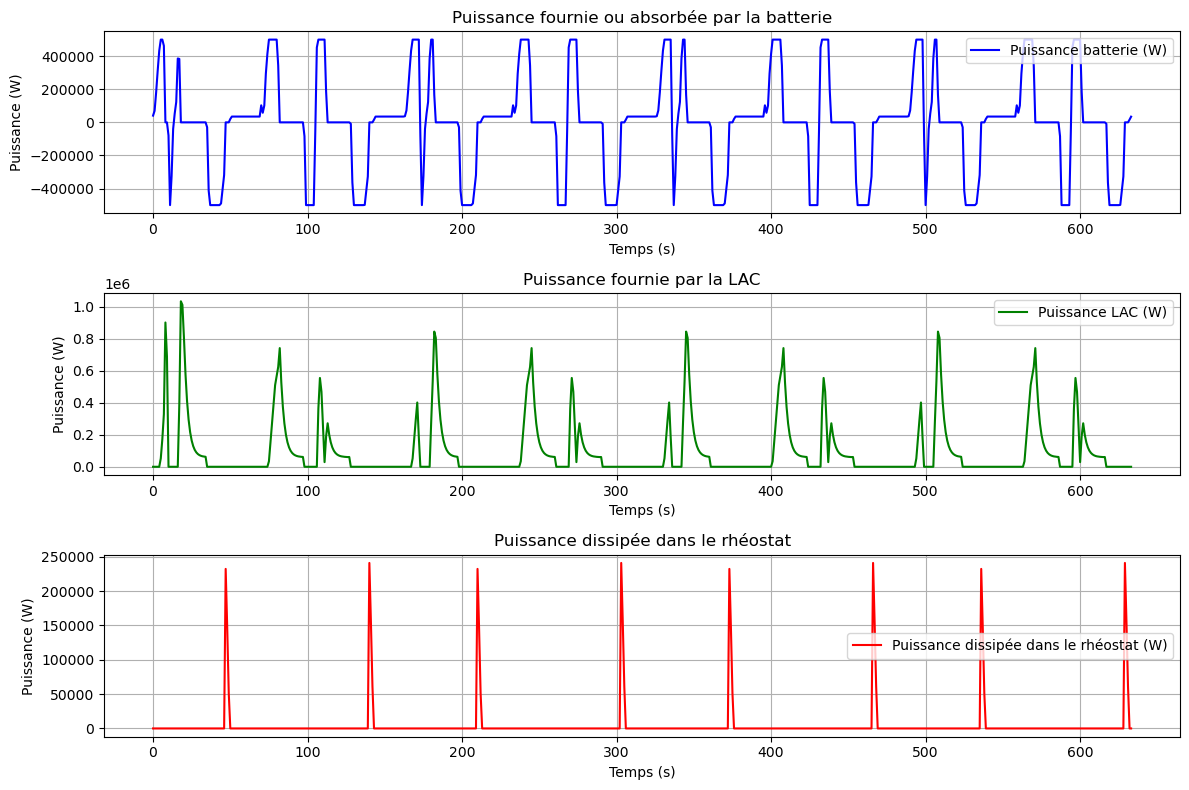

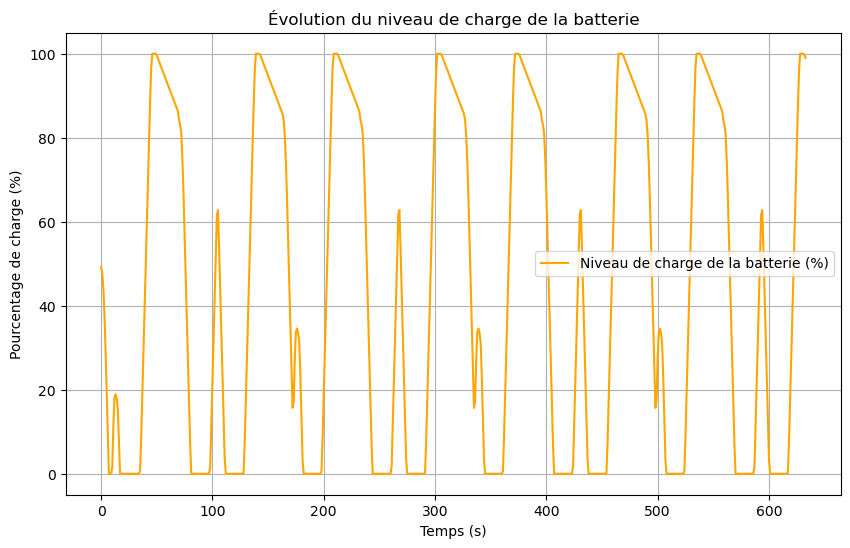

In [14]:
# Initialisation des paramètres de la batterie
battery_capacity = 5000000  # Capacité de la batterie (J)
battery_level = 2500000     # Niveau initial de la batterie (J)
battery_output_capacity = 500000  # Puissance max fournie par la batterie (W)
battery_input_capacity = 500000   # Puissance max absorbée par la batterie (W)
Dt = 1

# Liste pour stocker les résultats de la batterie
P_battery_list = []
P_LAC_list = []
P_rhéostat_list = []
battery_levels = []

# Boucle de simulation pour chaque point de données
for t in range(len(Ptrain)):
    p = Ptrain[t]  # Puissance du train à l'instant t
    # Appel de la fonction de gestion de la batterie
    P_battery, P_LAC, P_rhéostat, battery_level = gestion_batterie(
        p, battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt)
    
    # Stocker les résultats
    P_battery_list.append(P_battery)
    P_LAC_list.append(P_LAC)
    P_rhéostat_list.append(P_rhéostat)
    battery_levels.append(battery_level)

# Tracer les résultats
plt.figure(figsize=(12, 8))

# 1. Tracer de la puissance fournie par la batterie
plt.subplot(3, 1, 1)
plt.plot(temps, P_battery_list, label='Puissance batterie (W)', color='blue')
plt.title('Puissance fournie ou absorbée par la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

# 2. Tracer de la puissance fournie par la LAC
plt.subplot(3, 1, 2)
plt.plot(temps, P_LAC_list, label='Puissance LAC (W)', color='green')
plt.title('Puissance fournie par la LAC')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

# 3. Tracer de la puissance dissipée dans le rhéostat
plt.subplot(3, 1, 3)
plt.plot(temps, P_rhéostat_list, label='Puissance dissipée dans le rhéostat (W)', color='red')
plt.title('Puissance dissipée dans le rhéostat')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()


# Convertir la liste battery_levels en un tableau NumPy pour effectuer des opérations vectorielles
battery_levels_np = np.array(battery_levels)

# Calcul du pourcentage de charge de la batterie
battery_prctg = 100 * battery_levels_np / battery_capacity

# Tracer de l'évolution du pourcentage de charge de la batterie
plt.figure(figsize=(10, 6))
plt.plot(temps, battery_prctg, label='Niveau de charge de la batterie (%)', color='orange')
plt.title('Évolution du niveau de charge de la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Pourcentage de charge (%)')
plt.legend()
plt.grid(True)
plt.show()


Chute de tension maximale : 340.16 V


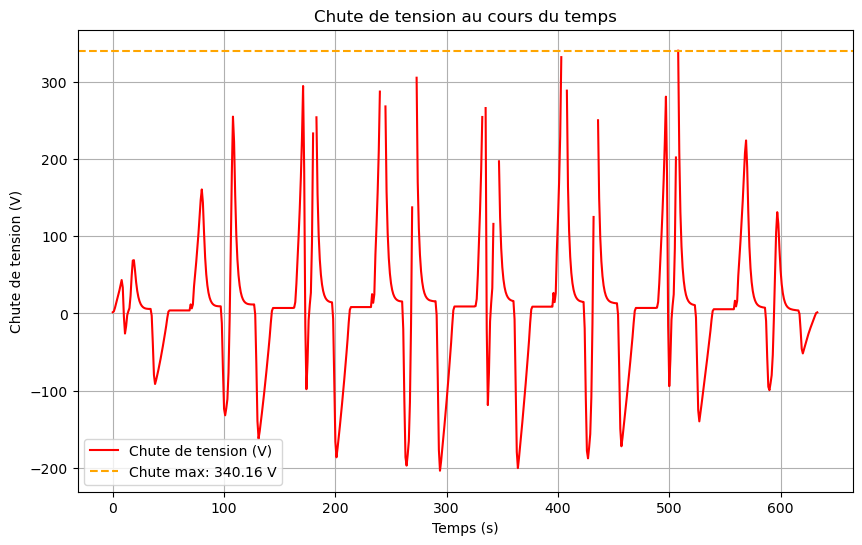

In [13]:
chutes_de_tension_simulation = []

# Boucle pour calculer la chute de tension à chaque instant
for idx in range(len(temps)):
    chute_tension = Vsst - Vtrain[idx]  # Vsst est la tension nominale
    chutes_de_tension_simulation.append(chute_tension)

# Calcul de la chute de tension maximale
chute_de_tension_maximale = max(chutes_de_tension_simulation)
print(f"Chute de tension maximale : {chute_de_tension_maximale:.2f} V")

# Tracer la chute de tension au cours du temps
plt.figure(figsize=(10, 6))
plt.plot(temps, chutes_de_tension_simulation, label="Chute de tension (V)", color='red')
plt.axhline(y=chute_de_tension_maximale, color='orange', linestyle='--', label=f'Chute max: {chute_de_tension_maximale:.2f} V')
plt.title('Chute de tension au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Chute de tension (V)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(temps, chutes_de_tension_simulation, label="Chute de tension (V)", color='red')
plt.axhline(y=chute_de_tension_maximale, color='orange', linestyle='--', label=f'Chute max: {chute_de_tension_maximale:.2f} V')
plt.title('Chute de tension au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Chute de tension (V)')
plt.legend()
plt.grid(True)
plt.show()

Max = 340.15850752075164, moy = 30.63800641825569


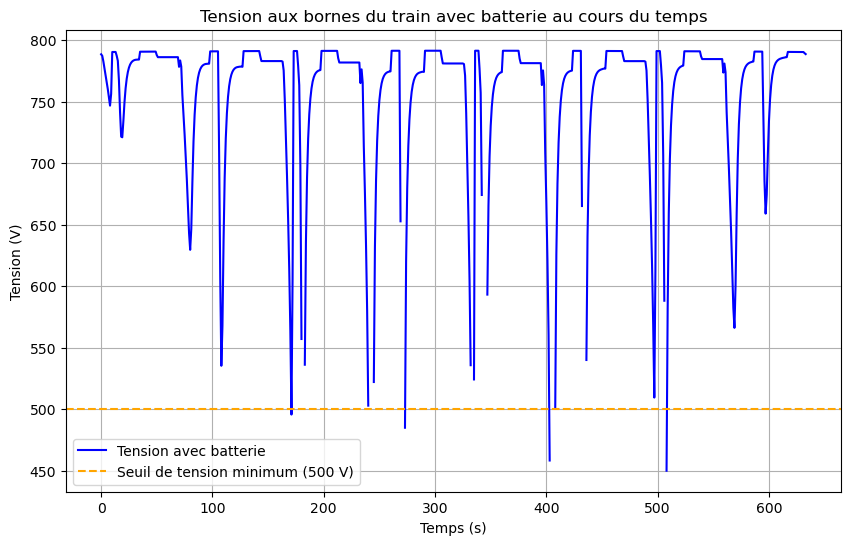

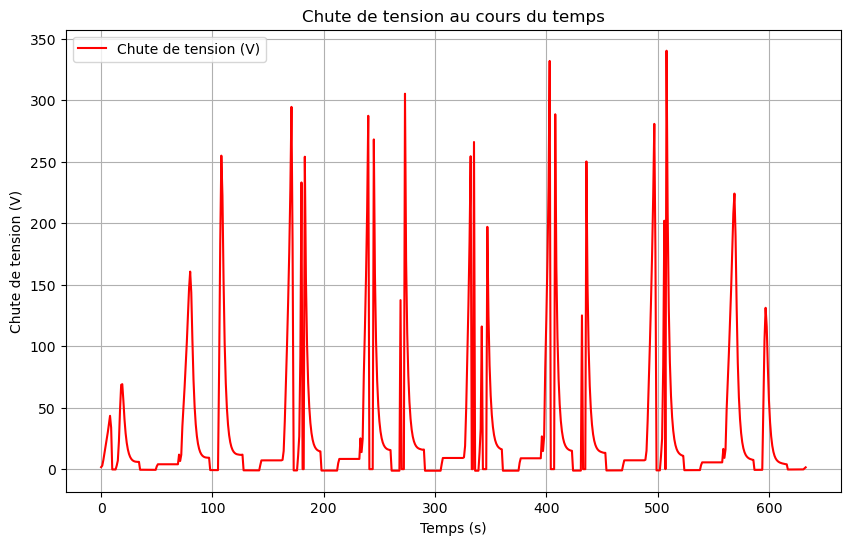

In [97]:
battery_capacity = 5000000  # Capacité de la batterie (J)
battery_level = 2500000    # Niveau initial de la batterie (J)
battery_output_capacity = 5000  # Puissance max fournie par la batterie (W)
battery_input_capacity = 5000   # Puissance max absorbée par la batterie (W)

# battery_capacity = 0  # Capacité de la batterie (J)
# battery_level = 0    # Niveau initial de la batterie (J)
# battery_output_capacity = 0  # Puissance max fournie par la batterie (W)
# battery_input_capacity = 0   # Puissance max absorbée par la batterie (W)


Dt = 1
# Simulation avec batterie pour chaque étape de temps
Vtrain = []  # Initialisation de la liste pour stocker la tension ajustée
chutes_de_tension = []  # Stocke les chutes de tension à chaque instant

for idx in range(len(temps)):
    # Gestion de la batterie : calcul des puissances fournies par la batterie et la LAC
    P_battery, P_LAC, P_rhéostat, battery_level = gestion_batterie(
        Ptrain[idx], battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt)
    
    
    
    # Puissance totale disponible pour le train (LAC + Batterie)
    P_total = P_LAC + P_battery - P_rhéostat
    # print(P_total - Ptrain[idx])

    x = position_x[idx]
    Req = calculer_Req(x)        
    # Calcul de la chute de tension en fonction de la puissance totale et de la résistance équivalente
    delta = Vsst**2 - 4 * Req * P_total
    # print(delta)
    if delta >= 0:
        V = 0.5 * (Vsst + np.sqrt(delta))
    else:
        V = np.nan  # En cas de chute excessive ou calcul non défini, utiliser NaN (pas de 0 brutal)

    Vtrain.append(V)  # Ajouter la tension calculée à la liste Vtrain
    chute_tension = Vsst - V if not np.isnan(V) else 0  # Calculer la chute de tension
    chutes_de_tension.append(chute_tension)

print(f"Max = {max(chutes_de_tension)}, moy = {np.mean(chutes_de_tension)}" )
# Affichage des résultats dans le notebook
plt.figure(figsize=(10, 6))
plt.plot(temps, Vtrain, label='Tension avec batterie', color='blue')
plt.axhline(y=500, color='orange', linestyle='--', label="Seuil de tension minimum (500 V)")
plt.title('Tension aux bornes du train avec batterie au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps, chutes_de_tension, label='Chute de tension (V)', color='red')
plt.title('Chute de tension au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Chute de tension (V)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(P_total - P)


0.0


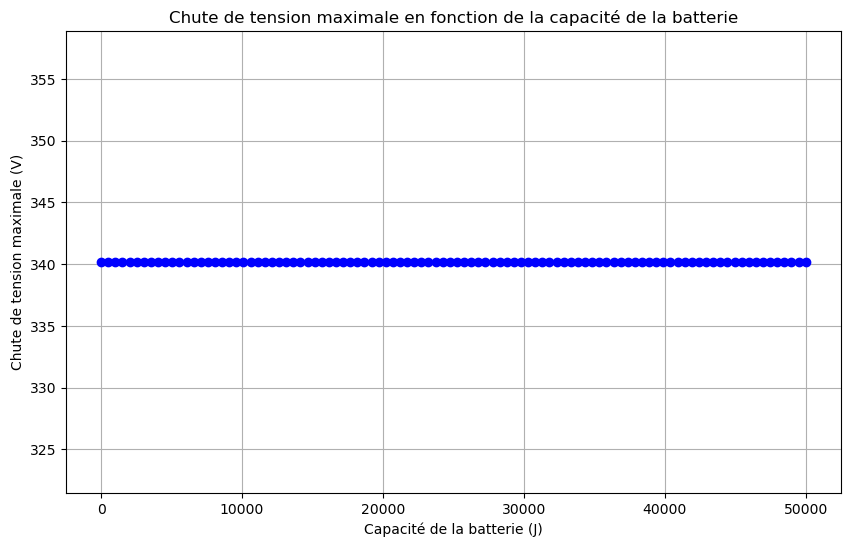

In [36]:
capacities = np.linspace(0, 50000, 100)  # Ex : de 0 à 500 000 J, en 10 points
chute_de_tension_maximales = []  # Stocke les chutes de tension maximales pour chaque capacité

# Simulation pour chaque capacité
for battery_capacity in capacities:
    battery_output_capacity = battery_capacity  # (W)
    battery_input_capacity = battery_capacity 
    battery_level = battery_capacity / 2  # Niveau initial de la batterie à 50%
    Vtrain = []
    chutes_de_tension = []
    
    for idx in range(len(temps)):
        x = position_x[idx]
        Req = calculer_Req(x)
        
        P_battery, P_LAC, P_rhéostat, battery_level = gestion_batterie(
            Ptrain[idx], battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt
        )
        
        P_total = P_LAC + P_battery - P_rhéostat
        
        x = position_x[idx]
        Req = calculer_Req(x)   
        
        # Calcul de la tension
        delta = Vsst**2 - 4 * Req * P_total
        if delta >= 0:
            V = 0.5 * (Vsst + np.sqrt(delta))
        else:
            V = np.nan
        
        Vtrain.append(V)
        chute_tension = Vsst - V if not np.isnan(V) else 0
        chutes_de_tension.append(chute_tension)

    # Chute de tension maximale pour cette capacité
    chute_max = max(chutes_de_tension)
    chute_de_tension_maximales.append(chute_max)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(capacities, chute_de_tension_maximales, marker='o', color='blue')
plt.title('Chute de tension maximale en fonction de la capacité de la batterie')
plt.xlabel('Capacité de la batterie (J)')
plt.ylabel('Chute de tension maximale (V)')
plt.grid(True)
plt.show()